In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'fashion_mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try2f_t10_r.4'
details['ratio'] = 0.4
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = int(details['ratio']*20000/(784+10))
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')
def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(1000)
    train_indices = torch.randint(60000-1, (20000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    for i, (data, label) in enumerate(train_loader):
        X_mat[i] = data.flatten()
        y_mat[i] = label.flatten()
    print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
        grad_norm = grad_norm_sq.sqrt()
        return grad_norm.cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None, fast_X_train=None, fast_y_train=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        ## Moving to gpu
        fast_X_train = fast_X_train.to(device)
        fast_y_train = fast_y_train.to(device)
        
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = list(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    # print('appended:',grad_norm_per_update)
                    # print(f'store gen err:{store_gen_err}')
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    self.optimizer.zero_grad()
                    hess_norms_per_update = self.get_hessianv2(X,y)
                    # print(f'\thess norm:{hess_norms_per_update}')
                    self.hess_norms.append(hess_norms_per_update)
                    #self.hess_norms.append(self.get_hessian(X,y))
                    
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    train_loss, test_loss=0, 0
                    if (fast_y_train is None) or (fast_X_train is None):
                        with torch.no_grad():
                            for sub_batch, (X_local,y_local) in enumerate(train_loader):
                                if epoch==0 and sub_batch> batch: # only taking the visited points to calculate train loss
                                    break
                                X_local, y_local = X_local.to(device), y_local.to(device)
                                pred_local = self.model(X_local)
                                train_loss += self.loss_fn(pred_local, y_local).item()
                        train_loss = train_loss/(batch+1)
                    else:
                        # print('using fast train loss, epoch', epoch)
                        with torch.no_grad():
                            if epoch==0:
                                pred_local = self.model(fast_X_train[:batch+1])
                                train_loss = self.loss_fn(pred_local, fast_y_train[:batch+1]).item()
                                # print(f'train_loss:{train_loss}')
                            else:
                                pred_local = self.model(fast_X_train)
                                train_loss = self.loss_fn(pred_local, fast_y_train).item()
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                    self.gen_err.append(train_loss - test_loss)
                    
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                        
                if batch % 10000 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
            with open(gen_file_path, 'w+') as f:
                f.write('')
            
    for t in range(times):
        train_loader, test_loader, fast_X_train, fast_y_train = get_random_subset(train_data_all, test_data_all)
        print(f'Time:{t}')
        train_model = Train_nn(784, [weight], op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=True, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after, fast_X_train=fast_X_train, fast_y_train=fast_y_train)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        with open(gen_file_path,'a+') as f:
            f.write(' '.join([str(gen_e) for gen_e in train_model.gen_err]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list
# grad_list, hess_norm_list=[],[]
grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:10


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

train data size:20000
test data size:1000
X_mat shape:torch.Size([20000, 784]), y_mat shape:torch.Size([20000])
Time:0


  0%|          | 0/20000 [00:00<?, ?batch/s]

	accuracy:11.4
	loss: 2.509024


KeyboardInterrupt: 

In [2]:
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(100)
    train_indices = torch.randint(60000-1, (2000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    for i, (data, label) in enumerate(train_loader):
        X_mat[i] = data.flatten()
        y_mat[i] = label.flatten()
    print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader, X_mat, y_mat


    # fig, ax = plt.subplots(2)
    # for i, (data, label) in enumerate(train_loader):
    #     # count_train+=1
    #     if i< 2:
    #         ax[i].imshow(data.reshape(28,28))
    #     else:
    #         break
            
# for i in range(5):
#     get_random_subset(train_data_all, test_data_all)
train_loader_temp, test_loader_temp, X_train_temp, y_train_temp = get_random_subset(train_data_all, test_data_all)

train data size:2000
test data size:100
X_mat shape:torch.Size([2000, 784]), y_mat shape:torch.Size([2000])


In [17]:
train_model = Train_nn(784, [12], 10, lr= 0.1)
train_model.fit(train_loader_temp, test_loader_temp, epochs=1, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=True, store_pt_loss=False, store_weights=False, freq_reduce_by = 40, freq_reduce_after=1, fast_X_train=X_train_temp, fast_y_train=y_train_temp)

  0%|          | 0/2000 [00:00<?, ?batch/s]

appended: tensor(3.9513, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:1.5174301862716675
	accuracy:11.0
	loss: 2.261410
appended: tensor(4.5444, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.1730642318725586
appended: tensor(3.0902, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.171642303466797
appended: tensor(4.1102, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.199967622756958
appended: tensor(3.0810, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.190607786178589
appended: tensor(3.2957, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.194854497909546
appended: tensor(2.8664, dtype=torch.float64)
store gen err:True
using fast train loss, epoch 0
train_loss:2.1917645931243896
appended: tensor(5.8451, dtype=torch.float64)
store gen err:True
using fast train loss, epo

In [36]:
print(X_train_temp.shape, y_train_temp.shape)

torch.Size([20000, 784]) torch.Size([20000])


In [37]:
temp_net = Net( 784, [12], 10)

In [46]:
temp_out=temp_net(X_train_temp[:100])
temp_out.shape

torch.Size([100, 10])

In [47]:
torch.nn.CrossEntropyLoss()(temp_out, y_train_temp[:100])

tensor(2.3111, grad_fn=<NllLossBackward0>)

In [ ]:
torch.randint(100, (10,))

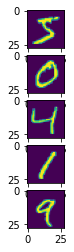

In [15]:
count_train = 0
fig, ax = plt.subplots(5)
for i, (data, label) in enumerate(train_loader):
    # count_train+=1
    if i< 5:
        ax[i].imshow(data.reshape(28,28))
    else:
        break


In [8]:
print(count_train)

20000
